In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')
figsize=(8,6)


def load_df(path, columns=None, nthreads=4, strings_to_categorical=True):
    try:
        table = pq.read_table(path, columns=columns, nthreads=nthreads)
        return table.to_pandas(strings_to_categorical=strings_to_categorical)
    except Exception as e:
        print(e)

        
def prepare(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on', 
            'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 'nfc_enabled',
            'unknown_sources', 'developer_mode']
    
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)

    df = df.reset_index(drop=True)

    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')

    df[converted_int.columns] = converted_int
    
    return df
    
df = prepare('../src/samples.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4587326 entries, 0 to 4587325
Data columns (total 11 columns):
device_id              uint16
timestamp              datetime64[ns]
battery_level          uint8
network_status         category
screen_on              uint8
bluetooth_enabled      uint8
location_enabled       uint8
power_saver_enabled    uint8
nfc_enabled            uint8
unknown_sources        uint8
developer_mode         uint8
dtypes: category(1), datetime64[ns](1), uint16(1), uint8(8)
memory usage: 83.1 MB


In [2]:
df.network_status.value_counts()

wifi             2458197
disconnected     1360836
lte               433236
hspap             133264
utms               79950
0                  41508
hspa               36341
edge               22118
disconnecting      12470
hsupa               4228
hsdpa               3377
gprs                1421
connecting            99
19                    78
20                    71
evdo_a                47
30                    37
1xrtt                 30
16                    17
18                     1
Name: network_status, dtype: int64

In [3]:
# additional features
df['wifi_enabled'] = (df['network_status'] == 'wifi').astype(np.uint8)

df['time_diff'] = df['timestamp'].diff()
df.loc[df.device_id != df.device_id.shift(), 'time_diff'] = None
df['time_diff'] = df.time_diff.dt.total_seconds()

df['discharging'] = df.battery_level.shift() >= df.battery_level
df.loc[df.device_id != df.device_id.shift(), 'discharging'] = None
df.head()

,device_id,timestamp,battery_level,network_status,screen_on,bluetooth_enabled,location_enabled,power_saver_enabled,nfc_enabled,unknown_sources,developer_mode,wifi_enabled,time_diff,discharging
0,1,2017-10-15 18:36:46,99,lte,1,0,1,0,0,0,0,0,NaN,NaN
1,1,2017-10-15 18:41:54,98,lte,1,0,1,0,0,0,0,0,308.0,1.0
2,1,2017-10-15 18:46:54,97,lte,1,0,1,0,0,0,0,0,300.0,1.0
3,1,2017-10-15 18:50:35,96,lte,1,0,1,0,0,0,0,0,221.0,1.0
4,1,2017-10-15 18:54:14,95,lte,1,0,1,0,0,0,0,0,219.0,1.0


In [4]:
df.discharging.value_counts(dropna=False) # discharge:1 charge:0

 0.0    2319693
 1.0    2266036
NaN        1597
Name: discharging, dtype: int64

In [5]:
seqs = df.groupby('device_id').discharging.value_counts().unstack()
seqs.columns = ['charging', 'discharging']
seqs.head()

,charging,discharging
device_id,,
1,2227.0,2574.0
4,6779.0,8393.0
6,12639.0,23514.0
10,1536.0,1124.0
12,18845.0,26301.0


In [6]:
df.groupby(['device_id', 'discharging']).time_diff.agg(['mean', 'min', 'max']).head()

mean  min       max
device_id discharging                            
1         0.0           134.316120  1.0    3630.0
          1.0           671.087413  0.0   78227.0
4         0.0           341.196637  0.0  193964.0
          1.0          1609.112475  0.0   33022.0
6         0.0           478.561595  0.0   56012.0

[Text(0,0.5,'# Samples')]

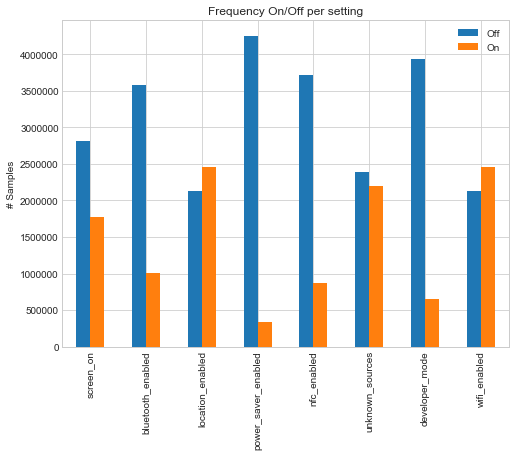

In [7]:
facts = ['screen_on', 'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 'nfc_enabled', 
         'unknown_sources', 'developer_mode', 'wifi_enabled']

# Frequency on/off per setting
freqs = df[facts].apply(pd.value_counts, axis=0).T
freqs.columns = ['Off', 'On']
fx = freqs.plot(kind='bar', title='Frequency On/Off per setting', figsize=figsize)
fx.set(ylabel='# Samples')

[Text(0,0.5,'# Samples'), Text(0.5,0,'Combinations')]

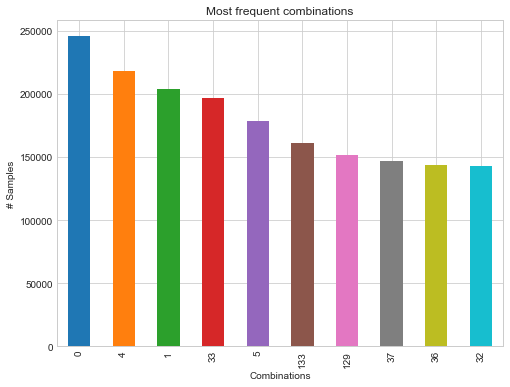

In [8]:
df['combination'] = np.packbits(df[facts].values, axis=-1)

# Most frequent combinations
combs = df.combination.value_counts()[0:10].T
cx = combs.plot(kind='bar', title='Most frequent combinations', figsize=figsize)
cx.set(xlabel='Combinations', ylabel='# Samples')

In [9]:
def unpack_comb(n):
    return np.unpackbits(np.array([n], dtype=np.uint8))

unpack_comb(133)

array([1, 0, 0, 0, 0, 1, 0, 1], dtype=uint8)